# Fitting IM Lup

This code runs the MCMC simulation to calculate the best fit parameters for the disk. It uses the logprob function from logprob_parallel.py.

In [1]:
import tempfile
from pathlib import Path
from multiprocessing import Pool

import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as c
import emcee

import dsharp_helper as dh
import dsharp_opac as do
import disklab
from gofish import imagecube

In [2]:
from helper_functions import get_profile_from_fits
from helper_functions import make_opacs
from helper_functions import chop_forward_scattering
from helper_functions import make_disklab2d_model
from helper_functions import write_radmc3d

In [3]:
from radmc3dPy import image

In [4]:
au = c.au.cgs.value
M_sun = c.M_sun.cgs.value
L_sun = c.L_sun.cgs.value
R_sun = c.R_sun.cgs.value

## ALMA data 

set the disk name and get some disk properties from DSHARP

In [5]:
disk = 'IMLup'
fname_mm_obs = dh.get_datafile(disk)

PA = dh.sources.loc[disk]['PA']
inc = dh.sources.loc[disk]['inc']
distance = dh.sources.loc[disk]['distance [pc]']

clip = 5

lam_mm = 0.125
RMS_jyb = 14e-6

Get the radial profile from the image

In [6]:
x_mm_obs, y_mm_obs, dy_mm_obs = get_profile_from_fits(
    fname_mm_obs,
    clip=clip,
    inc=inc, PA=PA,
    z0=0.0,
    psi=0.0)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


Compare against the DSHARP profile

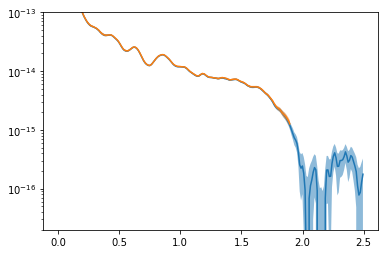

In [7]:
ds_prof = dh.get_profile(disk)

f, ax = plt.subplots()
ax.semilogy(x_mm_obs, y_mm_obs)
ax.fill_between(x_mm_obs, y_mm_obs - dy_mm_obs, y_mm_obs + dy_mm_obs, alpha=0.5)

ax.semilogy(ds_prof['r_as'], ds_prof['I_nu'])
ax.fill_between(ds_prof['r_as'], ds_prof['I_nu_l'], ds_prof['I_nu_u'], alpha=0.5)

ax.set_ylim(2e-17, 1e-13);

## Opacities

define the wavelength, size, and angle grids

then calculate opacities and store them in a local file, if it doesn't exist yet.

In [ ]:
%%time
n_lam = 200 # number of wavelength points
n_a = 15 # number of particle sizes
n_theta = 181 # number of angles in the scattering phase function
fname_opac = 'dustkappa_IMLUP.npz'

# wavelength and particle sizes grids

lam_opac = np.logspace(-5, 1, n_lam)
a_opac = np.logspace(-5, 1, n_a)

# make opacities if necessary

opac_dict = make_opacs(a_opac, lam_opac, fname=fname_opac, constants=None, n_theta=n_theta)

Please cite Warren & Brandt (2008) when using these optical constants
Please cite Draine 2003 when using these optical constants
Reading opacities from troilitek
Please cite Henning & Stognienko (1996) when using these optical constants
Reading opacities from organicsk
Please cite Henning & Stognienko (1996) when using these optical constants
| material                            | volume fractions | mass fractions |
|-------------------------------------|------------------|----------------|
| Water Ice (Warren & Brandt 2008)    | 0.3642           | 0.2            |
| Astronomical Silicates (Draine 2003)| 0.167            | 0.329          |
| Troilite (Henning)                  | 0.02578          | 0.07434        |
| Organics (Henning)                  | 0.443            | 0.3966         |
Mie ... 0 %

If the chopping does not work properly yet, we try to just use the original

In [11]:
fname_opac_chopped = fname_opac.replace('.', '_chopped.')

rho_s = opac_dict['rho_s']
m = 4 * np.pi / 3 * rho_s * a_opac**3

mueller = do.calculate_mueller_matrix(
    lam_opac, m,
    opac_dict['S1'],
    opac_dict['S2'],
    theta=opac_dict['theta'],
    k_sca=opac_dict['k_sca']
    )

zscat, zscat_nochop, k_sca, g = chop_forward_scattering(opac_dict)

opac_dict['k_sca'] = mueller['kscat_from_z11']
opac_dict['zscat'] = mueller['zscat']

do.write_disklab_opacity(fname_opac_chopped, opac_dict)

This part chops the very-forward scattering part of the phase function. This part is basically the same as no scattering, but are treated by the code as a scattering event. By cutting this part out of the phase function, we avoid those non-scattering scattering events. This needs to recalculate $\kappa_{sca}$ and $g$.

In [10]:
fname_opac_chopped = fname_opac.replace('.', '_chopped.')

k_sca_nochop = opac_dict['k_sca']
g_nochop = opac_dict['g']

zscat, zscat_nochop, k_sca, g = chop_forward_scattering(opac_dict)

opac_dict['k_sca'] = k_sca
opac_dict['zscat'] = zscat
opac_dict['g'] = g
rho_s = opac_dict['rho_s']
m = 4 * np.pi / 3 * rho_s * a_opac**3

do.write_disklab_opacity(fname_opac_chopped, opac_dict)

/Users/birnstiel/CODES/dsharp_opac/dsharp_opac/dsharp_opac.py:2000: UserWarning: Maximum error of 2.5e+14%: above error tolerance
  warnings.warn('Maximum error of {:.2g}%: above error tolerance'.format(error_max * 100))


## Emcee part

here we define some inputs and initial parameter sets for the optimization

In [12]:
# defining number of walkers
nwalkers = 25
ndim     = 7

# setting the priors for some parameters instead of letting them be uniform randoms between (0.1)

sigma_coeff_0   = 10**((np.random.rand(nwalkers)-0.5)*4)
others_0        = np.random.rand(ndim-3,nwalkers)
d2g_coeff_0     = (np.random.rand(nwalkers)+0.5) / 100
d2g_exp_0       = (np.random.rand(nwalkers)-0.5) 

# the input matrix of priors
p0 = np.vstack((sigma_coeff_0,others_0, d2g_coeff_0, d2g_exp_0)).T

# logprob testing

here we test the different steps that need to be taken in the logprob function

In [13]:
parameters = p0[0, :]
# The different indices in the parameters list correspond to different physical paramters
sigma_coeff = parameters[0]
sigma_exp = parameters[1]
size_exp = parameters[2]
amax_coeff = parameters[3]
amax_exp = parameters[4]
d2g_coeff = parameters[5]
d2g_exp = parameters[6]

In [14]:
testparameters =[
    7.0,
    0.730,
    0.558,
    0.017,
    0.625,
    0.008,
    0.050,
    ]

create a temporary folder in the current folder

In [15]:
temp_directory = tempfile.TemporaryDirectory(dir='.')
temp_path = temp_directory.name

set some disk specific parameters (the commented-out values are the ones that were used before)

In [16]:
# mstar = 0.7 * MS
# lstar = 1.56 * LS
# tstar = 4266.00

mstar = 10.**dh.sources.loc[disk]['log M_star/M_sun'] * M_sun
lstar = 10.**dh.sources.loc[disk]['log L_star/L_sun'] * L_sun
tstar = 10.**dh.sources.loc[disk]['log T_eff/ K']
rstar = np.sqrt(lstar / (4 * np.pi * c.sigma_sb.cgs.value * tstar**4))
PA = dh.sources.loc[disk]['PA']
inc = dh.sources.loc[disk]['inc']
dpc = dh.sources.loc[disk]['distance [pc]']

nr = 100
rin = 0.1 * au
r_c = 300 * au  # ??
rout = 400 * au  # 400au from avenhaus paper  #DSHARP Huang 2018 says 290 au
alpha = 1e-3

### make the disklab 2D model

/Users/birnstiel/Dropbox/projects/riccardo_franceschi/IMLup/helper_functions.py:67: UserWarning: Disk mass is unreasonably high: M_disk / Mstar = {d.mass/mstar:.2g}
  warnings.warn('Disk mass is unreasonably high: M_disk / Mstar = {d.mass/mstar:.2g}')


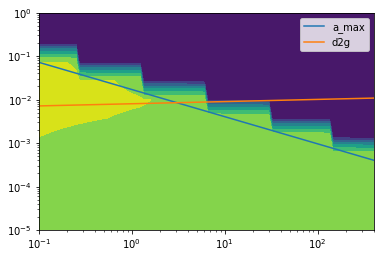

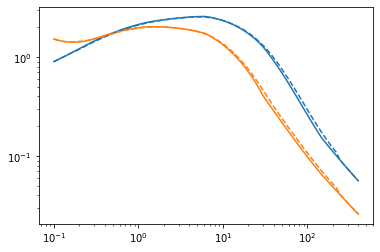

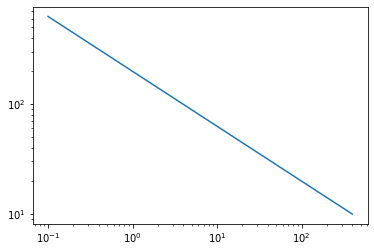

In [17]:
disk2d  = make_disklab2d_model(
    testparameters,
    mstar,
    lstar,
    tstar,
    nr,
    alpha,
    rin,
    rout,
    r_c,
    fname_opac_chopped,
    show_plots=True
)

In [18]:
print(f'disk to star mass ratio = {disk2d.disk.mass / disk2d.disk.mstar:.2g}')

disk to star mass ratio = 0.3


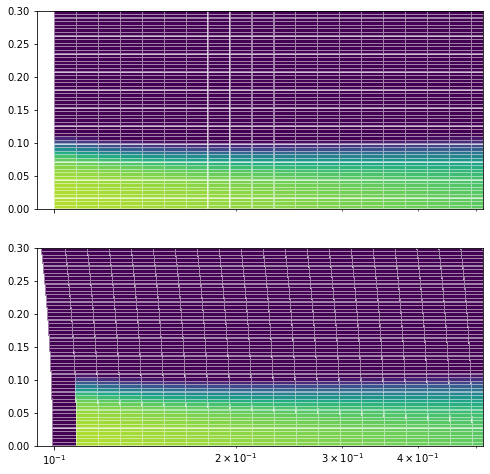

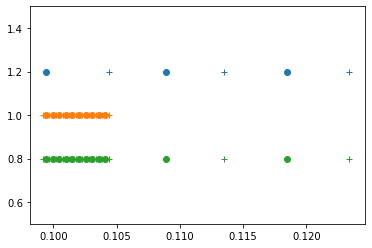

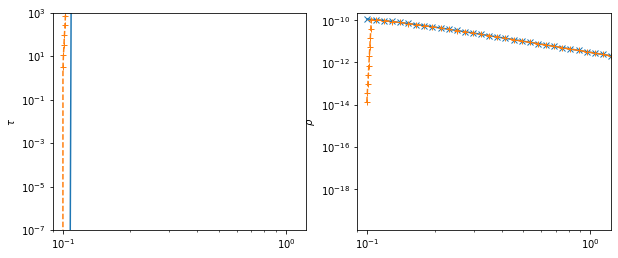

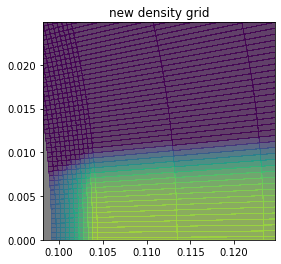

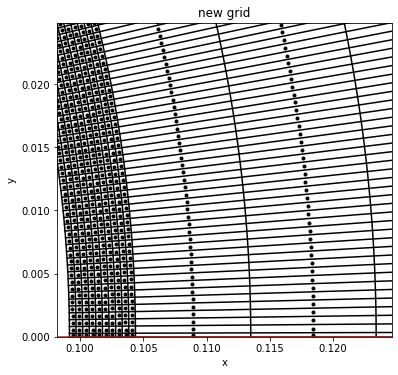

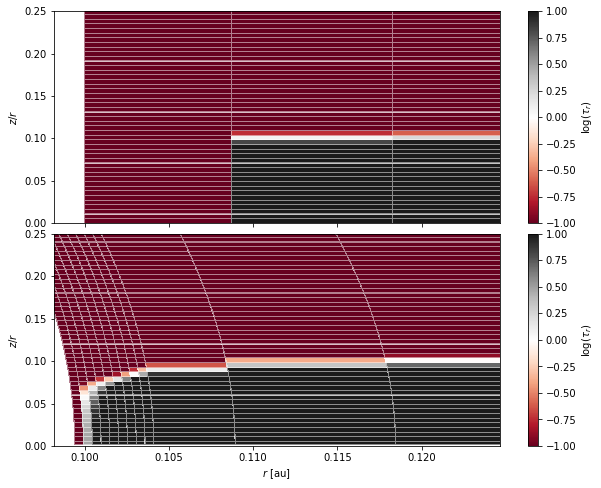

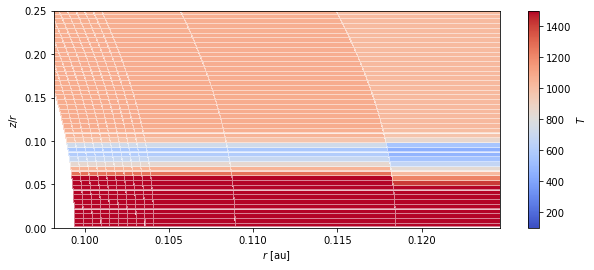

In [19]:
write_radmc3d(disk2d, lam_opac, temp_path, show_plots=True)

## Calculate the mm continuum image

In [20]:
fname_mm_sim = Path(temp_path) / 'image.fits'
disklab.radmc3d.radmc3d(
    f'image incl {inc} posang {PA-90} npix 500 lambda {lam_mm * 1e4} sizeau {2 * rout / au} secondorder  setthreads 1',
    path=temp_path)

>>>   
>>>    ================================================================
>>>         WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER
>>>   
>>>           This is the 3-D reincarnation of the 2-D RADMC code
>>>                   (c) 2010/2015 Cornelis Dullemond
>>>   
>>>    ************* NOTE: THIS IS STILL A BETA VERSION ***************
>>>    ****** Some modes/capabilities are not yet ready/mature ********
>>>   
>>>          Please feel free to ask questions. Also please report
>>>           bugs and/or suspicious behavior without hestitation.
>>>         The reliability of this code depends on your vigilance!
>>>   
>>>      To keep up-to-date with bug-alarms and bugfixes, register to
>>>         the RADMC-3D mailing list by sending an email to me:
>>>                       dullemond@uni-heidelberg.de
>>>   
>>>                 Please visit the RADMC-3D home page at
>>>     http://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/
>>>    =========================

In [21]:
im_mm_sim = image.readImage(str(fname_mm_sim.with_suffix('.out')))
im_mm_sim.writeFits(str(fname_mm_sim), dpc=dpc, coord='15h56m09.17658s -37d56m06.1193s')

Read in the fits files into imagecubes, and copy the beam information from the observation to the simulation.

In [22]:
iq_obs = imagecube(str(fname_mm_obs))

iq_sim = imagecube(str(fname_mm_sim))
iq_sim.bmaj, iq_sim.bmin, iq_sim.bpa = iq_obs.beam
iq_sim.beamarea_arcsec = iq_sim._calculate_beam_area_arcsec()
iq_sim.beamarea_str = iq_sim._calculate_beam_area_str()

In [23]:
x_mm_sim, y_mm_sim, dy_mm_sim = get_profile_from_fits(
    str(fname_mm_sim),
    clip=clip,
    inc=inc, PA=PA,
    z0=0.0,
    psi=0.0,
    beam=iq_obs.beam)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


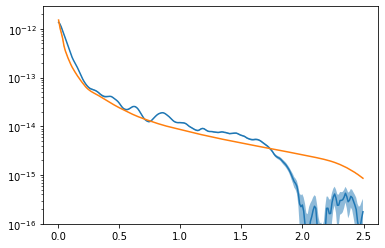

In [24]:
f, ax = plt.subplots()
ax.semilogy(x_mm_obs, y_mm_obs)
ax.fill_between(x_mm_obs, y_mm_obs - dy_mm_obs, y_mm_obs + dy_mm_obs, alpha=0.5)

ax.semilogy(x_mm_sim, y_mm_sim)
ax.fill_between(x_mm_sim, y_mm_sim - dy_mm_sim, y_mm_sim + dy_mm_sim, alpha=0.5)

ax.set_ylim(bottom=1e-16);

In [25]:
i_max = max(len(x_mm_obs), len(x_mm_sim))

x_mm_sim = x_mm_sim[:i_max]
y_mm_sim = y_mm_sim[:i_max]
x_mm_obs = x_mm_obs[:i_max]
y_mm_obs = y_mm_obs[:i_max]

if not np.allclose(x_mm_sim, x_mm_obs):
    raise AssertionError('observed and simulated radial profile grids are not equal')

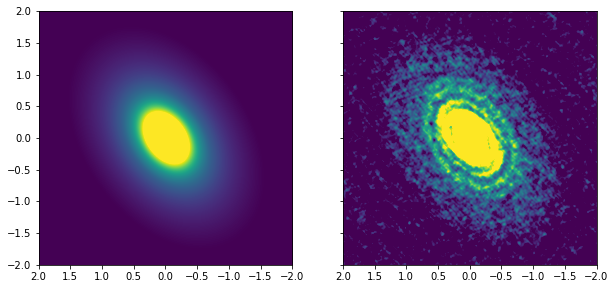

In [26]:
im_cgs_sim = iq_sim.data * iq_sim.pix_per_beam / iq_sim.beamarea_str * 1e-23
im_cgs_obs = iq_obs.data / iq_sim.beamarea_str * 1e-23

f, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
vmin = RMS_jyb * 1e-23 / iq_obs.beamarea_str # the RMS from dsharp (Jy/beam) to CGS conversion
vmax = 10 * vmin
ax[0].imshow(im_cgs_sim, extent=iq_sim.extent, vmin=vmin, vmax=vmax)
ax[1].imshow(im_cgs_obs, extent=iq_obs.extent, vmin=vmin, vmax=vmax)
ax[0].set_xlim([2, -2])
ax[0].set_ylim([-2, 2]);

Calculate the log probability for the mm here

In [26]:
log_prob_mm = -0.5 * np.sum((np.interp(observed_radius, radial / 158,
                                       radial_profile) - observed_intensity)**2 / (observed_intensity_error**2)) / len(observed_radius)

NameError: name 'observed_radius' is not defined

# Scattered light

To deproject the scattered light image, we will need to know where the scattering surface is. This is based on the Avenhaus et al. 2018 paper. In `imagecube` this surface can be defined with `z0` and `psi` such that its height $z$ is at

$\mathsf{z = z0 \, \left(\frac{r}{arcsec}\right)^{psi}}\, arcsec$

In [27]:
z0 = 0.2
psi = 1.27
lam_sca = 1.65e-4

In [28]:
# CUT OUT OPACITIES PART 2
from disklab.radmc3d import write
import dsharp_opac as opacity

#for p in Path(temp_path).glob('dustkappa_*.inp'):
#    p.unlink()

for i_grain in range(n_a):
    opacity.write_radmc3d_scatmat_file(i_grain, opac_dict, f'{i_grain}', path=temp_path)

In [29]:
with open(Path(temp_path) / 'dustopac.inp', 'w') as f:
    write(f, '2               Format number of this file')
    write(f, '{}              Nr of dust species'.format(n_a))

    for i_grain in range(n_a):
        write(f, '============================================================================')
        write(f, '10               Way in which this dust species is read')
        write(f, '0               0=Thermal grain')
        write(f, '{}              Extension of name of dustscatmat_***.inp file'.format(i_grain))

    write(f, '----------------------------------------------------------------------------')

# image calculation
disklab.radmc3d.radmc3d(f'image incl {inc} posang {PA-90} npix 500 lambda {lam_sca / 1e-4} sizeau {2 * rout / au} setthreads 4', path=temp_path)

fname_sca_img = Path(temp_path) / 'image.fits'
im = image.readImage(fname_sca_img.with_suffix('.out'))
im.writeFits(fname_sca_img, dpc=dpc, coord='15h56m09.17658s -37d56m06.1193s')

>>>   
>>>    ================================================================
>>>         WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER
>>>   
>>>           This is the 3-D reincarnation of the 2-D RADMC code
>>>                   (c) 2010/2015 Cornelis Dullemond
>>>   
>>>    ************* NOTE: THIS IS STILL A BETA VERSION ***************
>>>    ****** Some modes/capabilities are not yet ready/mature ********
>>>   
>>>          Please feel free to ask questions. Also please report
>>>           bugs and/or suspicious behavior without hestitation.
>>>         The reliability of this code depends on your vigilance!
>>>   
>>>      To keep up-to-date with bug-alarms and bugfixes, register to
>>>         the RADMC-3D mailing list by sending an email to me:
>>>                       dullemond@uni-heidelberg.de
>>>   
>>>                 Please visit the RADMC-3D home page at
>>>     http://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/
>>>    =========================

TypeError: unsupported operand type(s) for +: 'PosixPath' and 'str'

**TODO**

- check image brightness conversion of the sphere image

### read scattered light observations

In [ ]:
fname_sca_obs = 'Qphi_IMLup.fits'

clip = 3.0 # at how many arcsec to clip the image data

# fix the header of the sphere image
hdulist = fits.open(fname_sca_obs)
hdu0 = hdulist[0]

hdu0.header['cdelt1'] = -3.405e-06
hdu0.header['cdelt2'] = 3.405e-06
hdu0.header['crpix1'] = hdu0.header['naxis1'] // 2 + 1
hdu0.header['crpix2'] = hdu0.header['naxis2'] // 2 + 1
hdu0.header['crval1'] = 0.0
hdu0.header['crval2'] = 0.0
hdu0.header['crval3'] = 1.65e-4

# read it with imagecube and derive a radial profile

data = imagecube(hdulist, clip=clip)

x, y, dy = data.radial_profile(inc=inc, PA=PA, z0=z0, psi=psi)

# convert from Jy / beam to cgs

profile_sca = (y * u.Jy / data.beam_area_str).cgs.value
profile_sca_err = (dy * u.Jy / data.beam_area_str).cgs.value

### read scattered light RADMC3D image

In [ ]:
# calculating the profile from scattered light image using imagecube
sim_data = imagecube(fname_sca_img, clip=clip)

sim_x, sim_y, sim_dy = sim_data.radial_profile(inc=inc, PA=PA, z0=z0, psi=psi)

sim_profile = (sim_y * u.Jy / sim_data.beam_area_str).cgs.value
sim_profile_err = (sim_dy * u.Jy / sim_data.beam_area_str).cgs.value

profile = profile[x > 1]
profile_err = profile_err[x > 1]
x = x[x > 1]

sim_profile = sim_profile[sim_x > 1]
sim_profile_err = sim_profile_err[sim_x > 1]
sim_x = sim_x[sim_x > 1]

### calculate $\log P$

In [ ]:
log_prob_scat = -0.5 * np.nansum((np.interp(x, sim_x, sim_profile) - profile)**2 / (profile_err**2)) / len(x)

# adding the two log probs and then multiplying by a large factor in order to make the MCMC more sensitive to changes
log_prob = (log_prob_mm + log_prob_scat)

<hr>

**Here comes the rest of `MCMC_parallelized.py`, not cleaned up yet**

In [ ]:
print('step1')

# Parallelizing the simluation and running it for 250 iterations
with Pool(processes=100) as pool:
    sampler1 = emcee.EnsembleSampler(nwalkers, ndim, logprob, args=[profile, profile_err, x_arcsec], pool=pool)
    sampler1.run_mcmc(p0, 250)

print(sampler1.iteration)    

print('step2')
sampler2 = deepcopy(sampler1)
sampler2.log_prob_fn = None
with open('sampler.pickle', 'wb') as fid:
    pickle.dump(sampler2, fid)